# paper acceptance prediction
Aristoi

In [2]:
import pandas as pd
import numpy as np
import numpy as np
import gensim
import matplotlib.pyplot as plt

In [6]:
train_filename = "train_data.csv"
df = pd.read_csv(train_filename, index_col="id")

emb_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [10]:
X = []
y = []
for index, data in df.iterrows():
    title = data["title"]
    title = title.replace("-", " ")
    abstract = data["abstract"]

    emb_title = np.mean([emb_model[w.lower()] for w in title.split(" ") if w.lower() in emb_model], axis=0)
    emb_abstract = np.mean([emb_model[w] for w in abstract.split(" ") if w in emb_model], axis=0)
    if emb_title.ndim == 0:
        emb_title = np.zeros(300)
    X.append(np.concatenate([emb_title, emb_abstract], axis=0))
    y.append(data["y"])

In [11]:
X = np.array(X)
y = np.array(y)
X.shape, y.shape

((4974, 600), (4974,))

(array([3451.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1523.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

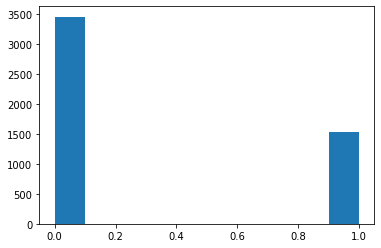

In [16]:
plt.hist(y)

In [18]:
import sklearn
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()

model.fit(X, y)

c:\Users\souon\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [19]:
model.score(X, y)

1.0

In [28]:
test_df = pd.read_csv("test_data.csv", index_col="id")


In [29]:
test_X = []
for index, data in test_df.iterrows():
    title = data["title"]
    title = title.replace("-", " ")
    abstract = data["abstract"]
    
    emb_title =  np.mean([emb_model[w.lower()] for w in title.split(' ') if w.lower() in emb_model], axis=0)
    emb_abstract =  np.mean([emb_model[w] for w in abstract.split(' ') if w in emb_model], axis=0)
    if emb_title.ndim == 0:
        emb_title = np.zeros(300)
    test_X.append(np.concatenate([emb_title, emb_abstract], axis=0))

c:\Users\souon\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\souon\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [30]:
test_predicted = model.predict(test_X)
submit_df = pd.DataFrame({"y": test_predicted})
submit_df.reset_index(drop=True)
submit_df.index += 1
submit_df.index.name = "id"
submit_df.to_csv("submission.csv")